## Импорт библиотек

In [1]:
# Для построения пайплайна обучения используется lightautoml, который конфликтуает с новой версией pandas. Поэтому
!pip uninstall pandas -y
!pip install --upgrade pip > installations.txt
!pip uninstall torch -y > installations.txt # конфликтует 
!pip install torch==2.0.0 > installations.txt
!pip install pandas==1.4.3 pyarrow yellowbrick polars transformers nltk gensim lightautoml > installations.txt
!pip install --upgrade -q wandb > installations.txt

Found existing installation: pandas 2.2.0
Uninstalling pandas-2.2.0:
  Successfully uninstalled pandas-2.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.14 requires pandas, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.14 requires pandas, which is not installed.
stable-baselines3 2.1.0 requires pandas, which is not installed.
torchaudio 2.1.2+cpu requires torch==2.1.2, but you have torch 2.0.0 which is incompatible.
torchtext 0.16.2+cpu requires torch==2.1.2, but you have torch 2.0.0 which is incompatible.
torchvision 0.16.2+cpu requires torch==2.1.2, but you have torch 2.0.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages t

In [2]:
# for dataframe
import polars as pl
import numpy as np
import pyarrow as pa
import pandas as pd

# for system
import os
import time
import sys

# for metric
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# for demention decrease
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# for common functions
from collections import OrderedDict
from collections import Counter
from kaggle_secrets import UserSecretsClient
from copy import deepcopy as copy
from typing import Tuple, List

# for monitoring of models
import wandb

# for machine learning
from lightautoml.reader.base import PandasToPandasReader
from lightautoml.tasks import Task
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.report.report_deco import ReportDeco

# my functions
sys.path.append('/kaggle/input/next-orders')
from my_functions import MarketDataProcessor

## Препроцессинг данных

____________________________________________________
Использовался ноутбук с TPU и RAM 300GB, чтобы не испытывать проблем с памятью во время операционных обработок датасета.

In [17]:
# tmp импорт в pandas
raw = pd.read_csv('../input/sbermarket-internship-competition/train.csv')
sub = pd.read_csv('../input/sbermarket-internship-competition/sample_submission.csv', sep = ",")

# Приведение столбца 'cart' к int
raw['cart'] = raw['cart'].astype(int)

mk_data = MarketDataProcessor(raw, sub)

# Отбрасываем выбросы - юзеров с малым количеством товаров в истории их заказов
filtered_raw, filtered_sub, proportion = mk_data.filter_train_data()
print(f"Процент наблюдений, используемый для тренировки: {proportion:.2f}%")

Процент наблюдений, используемый для тренировки: 0.97%


### Polars ускоряет обработку данных
__________________________________________________
В итоге мы получаем pd датафрейм с усредненным рейтингом id во всем датасете и набор временных переменных, основанных на этой метрике (рейтинг)

In [18]:
%%time
mk_data.get_dummies_matrix()
mk_data.generate_time_features()
Train = mk_data.compile_dataset()

Test = mk_data.compile_dataset(history_flag = 1)

CPU times: user 25min 34s, sys: 7min 45s, total: 33min 20s
Wall time: 3min 3s


### X / Y 

In [19]:
x_cols = Train.select_dtypes(include=['int', 'int8', 'int32', 'uint32', 'uint8', 'float']).drop(columns = ['target'], axis = 1).columns.tolist()
x_cols_pca = Train.select_dtypes(include=['int', 'int8', 'int32', 'uint32', 'uint8', 'float']).drop(columns = ['user_id', 'target'], axis = 1).columns.tolist()
print(x_cols)
y_cols = ['target']
print(y_cols)

['user_id', 'weekday_mean', 'weekday_max', 'weekday_min', 'weekday_std', 'month_mean', 'month_max', 'month_min', 'month_std', 'total_rating_mean', 'total_rating_max', 'total_rating_min', 'total_rating_std', 'rating_mean', 'rating_max', 'rating_min', 'rating_std', 'total_rating_cat_mean', 'total_rating_cat_max', 'total_rating_cat_min', 'total_rating_cat_std', 'ordered_mean', 'ordered_max', 'ordered_min', 'ordered_std', 'total_order_in_cat_mean', 'total_order_in_cat_max', 'total_order_in_cat_min', 'total_order_in_cat_std', 'total_order_num_mean', 'total_order_num_max', 'total_order_num_min', 'total_order_num_std', 't_rating_per_month_mean', 't_rating_per_month_std', 't_rating_per_month_sum', 't_rating_per_month_median', 'rating_per_month_mean', 'rating_per_month_std', 'rating_per_month_sum', 'rating_per_month_median', 'tc_rating_per_month_mean', 'tc_rating_per_month_std', 'tc_rating_per_month_sum', 'tc_rating_per_month_median', 't_rating_per_weekday_mean', 't_rating_per_weekday_std', 't_

### Добавляем главные компоненты

In [20]:
scaler = RobustScaler()

s_Train = Train.copy()
s_Test = Test.copy()
s_Train[x_cols_pca] = scaler.fit_transform(s_Train[x_cols_pca])
s_Test[x_cols_pca] = scaler.transform(s_Test[x_cols_pca])

pca = PCA(n_components=10)

s_Train_pca = pca.fit_transform(s_Train[x_cols])
s_Test_pca = pca.transform(s_Test[x_cols])

Train_pca = pd.DataFrame(s_Train_pca, columns=[f'pc{i+1}' for i in range(s_Train_pca.shape[1])])
Test_pca = pd.DataFrame(s_Test_pca, columns=[f'pc{i+1}' for i in range(s_Train_pca.shape[1])])

s_Train[Train_pca.columns.to_list()] = Train_pca
s_Test[Test_pca.columns.to_list()] = Test_pca

### Кластеризация id(юзер-категория)

Elbow Method to determine the number of clusters for id and target:


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

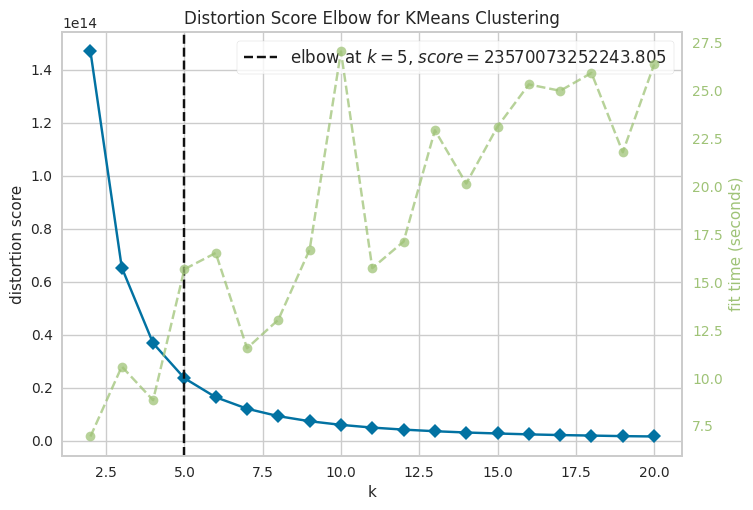

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=20, random_state=4), k=(2, 21))

In [25]:
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer

print('Elbow Method to determine the number of clusters for id and target:')
kelbow_visualizer(KMeans(random_state=4), 
                  Train_pca, 
                  k=(2,21))


In [27]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
cluster = kmeans.fit_predict(Train_pca)
test_cluster = kmeans.predict(Test_pca)
s_Train["Clusters"] = cluster
s_Test["Clusters"] = test_cluster

### Сохранение данных в parquet

In [30]:
# Train.to_parquet('Train.parquet', index=False)
# s_Train.to_parquet('s_Train.parquet', index=False)
# s_Test.to_parquet('s_Test.parquet', index=False)

In [3]:
s_Train = pd.read_parquet('/kaggle/input/next-orders/s_Train (1).parquet')
# s_Test = pd.read_parquet('/kaggle/input/next-orders/s_Test (1).parquet')

## LightAutoML пайплайн


In [4]:
def f1 (real, pred, **kwargs):
    return f1_score(real, (pred > 0.2).astype(int), **kwargs)

N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TARGET_NAME = 'target'
ROLES = {'target': TARGET_NAME, 'drop': ['id', 'user_id', 'category'], 'category': ['Clusters']}
TASK = Task('binary', metric = f1)

reader = PandasToPandasReader(TASK, cv=N_FOLDS, random_state=RANDOM_STATE)

lama_params = {
    "task": TASK,
    "cpu_limit": N_THREADS,
    "reader_params": {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
}
default_nn_params = {
    "bs": 128, "num_workers": 0, "path_to_save": None, "n_epochs": 1, "freeze_defaults": True
}

In [5]:
Train_set, Valid_set = train_test_split(s_Train, test_size = TEST_SIZE,
                                        stratify = None, random_state = 23)
Train_set.reset_index(drop=True, inplace=True)
Valid_set.reset_index(drop=True, inplace=True)

In [6]:
del s_Train

In [ ]:
real_estimators = ['total_order_in_cat_max',
 'ordered_mean',
 'pc2',
 'total_rating_cat_max',
 'rating_max',
 'rating_mean',
 'pc5',
 'weekday_mean',
 'pc6',
 'pc4',
 'pc10',
 'pc3',
 'pc1',
 'pc7',
 'pc8',
 'pc9',
 'rating_per_month_mean',
 'month_std',
 'month_mean',
 'rating_per_month_std',
 'weekday_std',
 'month_max',
 'ordered_std',
 'rating_std',
 'weekday_min',
 'month_min',
 't_rating_per_month_mean',
 'Clusters',
 'weekday_max',
 't_rating_per_month_sum',
 'tc_rating_per_month_mean',
 't_rating_per_month_median',
 't_rating_per_month_std',
 'tc_rating_per_month_sum',
 'ordered_max',
 'tc_rating_per_month_std']

In [28]:
%%time 

automl = TabularUtilizedAutoML(
    task = TASK,
    timeout = 3600 * 8,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    general_params = {'use_algos': 'auto'}
)


train_pred = automl.fit_predict(Train_set[:10000][real_estimators + ['target']], roles = ROLES, verbose = 2)

print('Score', "%.5f" % f1(Train_set[:10000].target, train_pred.data))
valid_pred = automl.predict(Valid_set[:10000][real_estimators + ['target']])
print('Score on out of folds validation', "%.5f" % f1(Valid_set[:10000].target, valid_pred.data))

[16:01:21] Start automl utilizator with listed constraints:
[16:01:21] - time: 500.00 seconds
[16:01:21] - CPU: 4 cores
[16:01:21] - memory: 16 GB

[16:01:21] If one preset completes earlier, next preset configuration will be started

[16:01:21] ==================================================
[16:01:21] Start 0 automl preset configuration:
[16:01:21] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[16:01:21] Stdout logging level is INFO2.
[16:01:21] Task: binary

[16:01:21] Start automl preset with listed constraints:
[16:01:21] - time: 500.00 seconds
[16:01:21] - CPU: 4 cores
[16:01:21] - memory: 16 GB

[16:01:21] Train data shape: (10000, 37)



/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:37: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[16:01:43] Layer 1 train process start. Time left 478.57 secs
[16:01:43] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[16:01:43] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[16:01:43] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[16:01:44] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[16:01:44] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[16:01:45] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[16:01:46] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.4132231404958677
[16:01:46] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[16:01:46] Time left 475.56 secs

[16:01:46] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[16:01:46] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[16:01:54] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[16:02:04] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_L

In [13]:
print(automl.create_model_str_desc())

Final prediction for new objects = 
	0.74248 * 1 averaged models with config = "conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.09250 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.06215 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.36218 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.48317 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	+ 0.25752 * 1 averaged models with config = "conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.38197 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.52949 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.08855 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 





In [ ]:
fast_fi = automl.get_feature_scores('fast', silent=False)
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

<Axes: xlabel='Feature'>

In [24]:
import joblib

joblib.dump(automl, 'automl_03.pkl')
automl=joblib.load('/kaggle/working/automl_03.pkl')

In [29]:
valid_pred = automl.predict(Valid_set)
print('Score on out of folds validation', "%.5f" % f1(Valid_set.target, valid_pred.data))

Score on out of folds validation 0.40035


### Нахождение лучшего порогового значения для сепарации 0 и 1

In [ ]:
best_score = 0
for i in np.arange(0.01, 1.0, 0.01):
    score = f1 = f1_score(Valid_set.target, (valid_pred.data > i).astype(int))
    if score > best_score:
        best_score = score
        proba_split = i

print('At i =', "%.2f" % proba_split,'score is : ' "%.5f" % best_score)

In [ ]:
s_Test['target'] = (predictions.data > proba_split).astype(int)
submit = pd.merge(sub['id'], s_Test[['id', 'target']], on='id')

## Подготовка сабмита

In [ ]:
import csv

with open('submission02.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(submit.columns)
    for row in submit.values:
        csvwriter.writerow(row)